In [1]:
import pandas as pd
import os
import numpy as np
from datetime import datetime, timedelta
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
import pandas_gbq

# Import

In [2]:
project_id = "rental-price-prediction"
query_landed = """
SELECT * FROM ura_data.landed_data;
"""
query_nonlanded = """
SELECT * FROM ura_data.nonlanded_data;
"""
landed = pandas_gbq.read_gbq(query_landed, project_id=project_id, dialect="standard")
nonlanded = pandas_gbq.read_gbq(query_nonlanded, project_id=project_id, dialect="standard")
# df = pd.read_csv("../data/rental_data_for_BI.csv")

Downloading: 100%|██████████|
Downloading: 100%|██████████|


# Split Data into Landed and Non-landed

In [3]:
# landed = df[(df["propertyType"] != "Non-landed Properties") & (df["propertyType"] != "Executive Condominium")].reset_index(drop=True) # Terrace House, Detached House, Semi-Detached House
# nonlanded = df[(df["propertyType"] == "Non-landed Properties") | (df["propertyType"] == "Executive Condominium")].reset_index(drop=True) # landed Properties, Executive Condominium
landed


,leaseDate,propertyType,district,noOfBedRoom,rent,street,x,y,project,refPeriod,psf75,median,psf25,areaSqft_formatted,leaseYear,leaseQuarter,leaseMonth
0,2021-01-01,Terrace House,22,-1,4100.0,YUNNAN CRESCENT,0.000000,0.000000,LANDED HOUSING DEVELOPMENT,2021Q1,NaN,NaN,NaN,2750.0,2021,1,1
1,2021-01-01,Terrace House,15,-1,4000.0,LORONG 105 CHANGI,0.000000,0.000000,LANDED HOUSING DEVELOPMENT,2021Q1,NaN,NaN,NaN,2250.0,2021,1,1
2,2021-01-01,Terrace House,14,-1,4800.0,LENGKONG DUA,0.000000,0.000000,LANDED HOUSING DEVELOPMENT,2021Q1,NaN,NaN,NaN,2250.0,2021,1,1
3,2021-01-01,Terrace House,15,-1,5000.0,JOO CHIAT TERRACE,0.000000,0.000000,LANDED HOUSING DEVELOPMENT,2021Q1,NaN,NaN,NaN,1250.0,2021,1,1
4,2021-01-01,Semi-Detached House,15,-1,11500.0,WILKINSON ROAD,0.000000,0.000000,LANDED HOUSING DEVELOPMENT,2021Q1,NaN,NaN,NaN,3750.0,2021,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20657,2023-12-01,Detached House,15,-1,11000.0,CRESCENT ROAD,34754.299537,31388.028947,SEVEN CRESCENT,2023Q4,NaN,NaN,NaN,4250.0,2023,4,12
20658,2023-12-01,Semi-Detached House,16,-1,7500.0,JALAN ANGIN LAUT,41392.236155,35420.963809,LANDED HOUSING DEVELOPMENT,2023Q4,NaN,NaN,NaN,3250.0,2023,4,12
20659,2023-12-01,Semi-Detached House,16,-1,7500.0,JALAN ANGIN LAUT,41392.236155,35420.963809,LANDED HOUSING DEVELOPMENT,2023Q4,NaN,NaN,NaN,3250.0,2023,4,12
20660,2023-12-01,Semi-Detached House,16,-1,7500.0,JALAN ANGIN LAUT,41392.236155,35420.963809,LANDED HOUSING DEVELOPMENT,2023Q4,NaN,NaN,NaN,3250.0,2023,4,12


In [6]:
nonlanded

,leaseDate,propertyType,district,noOfBedRoom,rent,street,x,y,project,refPeriod,psf75,median,psf25,areaSqft_formatted,leaseYear,leaseQuarter,leaseMonth
0,2021-03-01,Non-landed Properties,9,-1,4044.0,MOHAMED SULTAN ROAD,0.00000,0.00000,NON-LANDED HOUSING DEVELOPMENT,2021Q1,NaN,NaN,NaN,750.0,2021,1,3
1,2021-01-01,Non-landed Properties,8,-1,2200.0,SERANGOON ROAD,0.00000,0.00000,NON-LANDED HOUSING DEVELOPMENT,2021Q1,NaN,NaN,NaN,750.0,2021,1,1
2,2021-03-01,Non-landed Properties,9,-1,2300.0,MOHAMED SULTAN ROAD,0.00000,0.00000,NON-LANDED HOUSING DEVELOPMENT,2021Q1,NaN,NaN,NaN,550.0,2021,1,3
3,2021-03-01,Non-landed Properties,12,-1,5500.0,SERANGOON ROAD,0.00000,0.00000,NON-LANDED HOUSING DEVELOPMENT,2021Q1,NaN,NaN,NaN,1550.0,2021,1,3
4,2021-03-01,Non-landed Properties,14,-1,3000.0,CHANGI ROAD,0.00000,0.00000,NON-LANDED HOUSING DEVELOPMENT,2021Q1,NaN,NaN,NaN,1250.0,2021,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261121,2023-11-01,Non-landed Properties,9,2,6300.0,ROBERTSON QUAY,28448.46801,30367.56831,UP@ROBERTSON QUAY,2023Q4,NaN,NaN,NaN,1150.0,2023,4,11
261122,2023-12-01,Non-landed Properties,9,1,4200.0,ROBERTSON QUAY,28448.46801,30367.56831,UP@ROBERTSON QUAY,2023Q4,NaN,NaN,NaN,550.0,2023,4,12
261123,2023-12-01,Non-landed Properties,15,-1,10000.0,MEYER ROAD,34679.00573,30983.44594,THE SOVEREIGN,2023Q4,NaN,NaN,NaN,2650.0,2023,4,12
261124,2023-11-01,Non-landed Properties,15,-1,10200.0,MEYER ROAD,34679.00573,30983.44594,THE SOVEREIGN,2023Q4,NaN,NaN,NaN,2650.0,2023,4,11


In [8]:
landed["noOfBedRoom"].value_counts()

noOfBedRoom
-1    20662
Name: count, dtype: Int64

In [7]:
nonlanded["noOfBedRoom"].value_counts()

noOfBedRoom
2     82360
3     80720
1     54561
-1    23901
4     18678
5       852
6        36
0        11
8         6
7         1
Name: count, dtype: Int64

# One Hot Encoding

In [25]:
def encode_df(df):
    """ one hot encoding of features district and propertyType, first category dropped"""
    df['district'] = df['district'].astype('category')
    df['propertyType'] = df['propertyType'].astype('category')
    df = pd.get_dummies(df, columns=["district", "propertyType"], drop_first=True)
    return df

landed_encoded = encode_df(landed)
nonlanded_encoded = encode_df(nonlanded)

# Check null values

* Significant number of observations with missing IQR range for all propertyTypes. Difficult to impute values. Will not use IQR in modelling
* Very few ECs don't have noOfBedRoom. Impute with median
* Around 10% of Non-landed Properties don't have noOfBedRoom

In [26]:
print(f'total no. of Terrace House = {landed[landed["propertyType"] == "Terrace House"].shape[0]}')
print(f'total no. of Semi-Detached House = {landed[landed["propertyType"] == "Semi-Detached House"].shape[0]}')
print(f'total no. of Detached House = {landed[landed["propertyType"] == "Detached House"].shape[0]}')
print("\ncount of observations with missing IQR:")
landed[pd.isna(landed["median"])]["propertyType"].value_counts(dropna=False)

total no. of Terrace House = 9630
total no. of Semi-Detached House = 6509
total no. of Detached House = 4523

count of observations with missing IQR:


propertyType
Terrace House          9509
Semi-Detached House    6509
Detached House         4522
Name: count, dtype: int64

In [27]:
print(f'total no. of Non-landed Properties = {nonlanded[nonlanded["propertyType"] == "Non-landed Properties"].shape[0]}')
print(f'total no. of ECs = {nonlanded[nonlanded["propertyType"] == "Executive Condominium"].shape[0]}')
print("\ncount of observations with missing IQR:")
nonlanded[pd.isna(nonlanded["median"])]["propertyType"].value_counts(dropna=False)

total no. of Non-landed Properties = 255610
total no. of ECs = 5516

count of observations with missing IQR:


propertyType
Non-landed Properties    101092
Executive Condominium      5516
Name: count, dtype: int64

In [28]:
print("count of observations with missing noOfBedRoom:")
landed[landed["noOfBedRoom"] != -1]["propertyType"].value_counts(dropna=False) # all landed properties don't have noOfBedRoom

count of observations with missing noOfBedRoom:


propertyType
Detached House         0
Semi-Detached House    0
Terrace House          0
Name: count, dtype: int64

In [29]:
print(f'total no. of Non-landed Properties = {nonlanded[nonlanded["propertyType"] == "Non-landed Properties"].shape[0]}')
print(f'total no. of ECs = {nonlanded[nonlanded["propertyType"] == "Executive Condominium"].shape[0]}')
print("\ncount of observations with missing noOfBedRoom:")
nonlanded[nonlanded["noOfBedRoom"] == -1]["propertyType"].value_counts(dropna=False) 

total no. of Non-landed Properties = 255610
total no. of ECs = 5516

count of observations with missing noOfBedRoom:


propertyType
Non-landed Properties    23896
Executive Condominium        5
Name: count, dtype: int64

# Data Imputation

In [30]:
EC_median_noOfBedRoom = np.median(nonlanded[(nonlanded["propertyType"] == "Executive Condominium") & (nonlanded["noOfBedRoom"] != -1)]["noOfBedRoom"])
nonlanded[(nonlanded["propertyType"] == "Executive Condominium")]["median"] = nonlanded[(nonlanded["propertyType"] == "Executive Condominium")]["median"].fillna(EC_median_noOfBedRoom)

In [31]:
nonlandedproperties_median_noOfBedRoom = np.median(nonlanded[(nonlanded["propertyType"] == "Non-landed Properties") & (nonlanded["noOfBedRoom"] != -1)]["noOfBedRoom"])
nonlanded[(nonlanded["propertyType"] == "Non-landed Properties")]["median"] = nonlanded[(nonlanded["propertyType"] == "Non-landed Properties")]["median"].fillna(nonlandedproperties_median_noOfBedRoom)

# Functions

## VIF

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def get_VIF(features, df):
    # the independent variables set
    X = df[features]
    
    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                            for i in range(len(X.columns))]
    print(vif_data)#### Correlation Plot

## Correlation Plot

In [33]:
import seaborn as sns
def get_corr_plot(df):
    """all features must be numerical"""
    corr = df.corr()
    sns.set (rc = {'figure.figsize':(12,12)})
    sns.heatmap(corr, cmap='RdBu',annot=True, vmin=-1, vmax=1)


## Pairs Plot

In [34]:
def pairs(df):
    """all features must be numerical"""
    axes = pd.plotting.scatter_matrix(df, alpha=0.2, figsize = (10,10))
    plt.tight_layout()

## LRM

In [35]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

def run_lrm(X_train_df: pd.DataFrame, y_train: pd.Series, X_test_df: pd.DataFrame, y_test: pd.Series, features: list, scaler=None):

    X_train_df = X_train_df.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test_df = X_test_df.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    if scaler:
        X_train = X_train_df[features]
        X_train_scaled = scaler.fit_transform(X_train)
        X_train_scaled = sm.add_constant(X_train_scaled)
        # y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))

        X_test = X_test_df[features]
        X_test_scaled = scaler.fit_transform(X_test)
        X_test_scaled = sm.add_constant(X_test_scaled)
        # y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1,1))    
    else: # no scaling
        X_train_scaled = X_train_df[features]
        X_train_scaled = sm.add_constant(X_train_scaled)


        X_test_scaled = X_test_df[features]
        X_test_scaled = sm.add_constant(X_test_scaled)
    y_train_scaled = y_train
    y_test_scaled = y_test

    model = sm.OLS(y_train_scaled, X_train_scaled).fit()
    print(model.summary(xname=['const'] + features))

    # resid plot
    fitted_val = model.fittedvalues.copy()
    # true_val = y_train_scaled.copy().reshape(len(y_train_scaled,)) if scaler else y_train_scaled
    true_val = y_train_scaled
    residual = true_val - fitted_val
    result_df = pd.DataFrame({"fitted": fitted_val, "true": true_val, "resid": residual}) #"cid": X_train_df["CustomerID"],
    plt.figure(figsize=(4,4))
    plt.scatter(fitted_val, residual)
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.title("Residual against Predicted")
    plt.show()

    plt.figure(figsize=(4,4))
    plt.scatter(true_val, fitted_val)
    plt.xlabel("True Value")
    plt.ylabel("Fitted Value")
    plt.show()


    # testing
    pred_val = model.predict(X_test_scaled)
    # if scaler:
    #     print(f"MSE using testing data = {mean_squared_error(y_test_scaled.copy().reshape(len(y_test_scaled,)), pred_val)}")
    #     print(f"MAE using testing data = {mean_absolute_error(y_test_scaled.copy().reshape(len(y_test_scaled,)), pred_val)}")
    # else:
    print(f"MSE using testing data = {mean_squared_error(y_test_scaled, pred_val)}")
    print(f"RMSE using testing data= {mean_squared_error(y_test_scaled, pred_val, squared=False)}")
    print(f"MAE using testing data = {mean_absolute_error(y_test_scaled, pred_val)}")
    
    return {"model": model, "result_df": result_df}

### Backwards Selection

In [36]:
def backwards_selection(X_train_df: pd.DataFrame, y_train: pd.Series, X_test_df: pd.DataFrame, y_test: pd.Series, features: list, scaler=None):
    X_train_df = X_train_df.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test_df = X_test_df.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
    if scaler:
        X_train = X_train_df[features]
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_train_scaled = sm.add_constant(X_train_scaled)
        # y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))

        X_test = X_test_df[features]
        X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
        X_test_scaled = sm.add_constant(X_test_scaled)
        # y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1,1))    
    else: # no scaling
        X_train_scaled = X_train_df[features]
        X_train_scaled = sm.add_constant(X_train_scaled)


        X_test_scaled = X_test_df[features]
        X_test_scaled = sm.add_constant(X_test_scaled)
    y_train_scaled = y_train
    y_test_scaled = y_test

    # Fit the initial model with all predictors    
    model = sm.OLS(y_train_scaled, X_train_scaled)
    results = model.fit()
    # print(model.summary(xname=['const'] + features))

    significance_threshold = 0.05

    # Perform backward selection
    while True:
        # Get the p-values of the predictor variables
        p_values = results.pvalues[1:]  # Exclude the constant term

        # Find the predictor with the highest p-value
        max_p_value = p_values.max()
        max_p_index = p_values.idxmax()

        # Check if the highest p-value exceeds the significance threshold
        if max_p_value > significance_threshold:
            # Remove the predictor with the highest p-value
            X_train_scaled = X_train_scaled.drop(max_p_index, axis=1)
            model = sm.OLS(y_train_scaled, sm.add_constant(X_train_scaled)) # .astype(float)
            results = model.fit()
        else:
            break

    # Final model after backward selection
    print(results.summary())


    # resid plot
    fitted_val = results.fittedvalues.copy()
    # true_val = y_train_scaled.copy().reshape(len(y_train_scaled,)) if scaler else y_train_scaled
    true_val = y_train_scaled
    residual = true_val - fitted_val
    result_df = pd.DataFrame({"fitted": fitted_val, "true": true_val, "resid": residual}) #"cid": X_train_df["CustomerID"],
    plt.figure(figsize=(4,4))
    plt.scatter(fitted_val, residual)
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.title("Residual against Predicted")
    plt.show()

    plt.figure(figsize=(4,4))
    plt.scatter(true_val, fitted_val)
    plt.xlabel("True Value")
    plt.ylabel("Fitted Value")
    plt.show()


    # testing
    chosen_cols = results.params.index
    pred_val = results.predict(X_test_scaled[chosen_cols])
    # if scaler:
    #     print(f"MSE using testing data = {mean_squared_error(y_test_scaled.copy().reshape(len(y_test_scaled,)), pred_val)}")
    #     print(f"MAE using testing data = {mean_absolute_error(y_test_scaled.copy().reshape(len(y_test_scaled,)), pred_val)}")
    # else:
    print(f"MSE using testing data = {mean_squared_error(y_test_scaled, pred_val)}")
    print(f"RMSE using testing data= {mean_squared_error(y_test_scaled, pred_val, squared=False)}")
    print(f"MAE using testing data = {mean_absolute_error(y_test_scaled, pred_val)}")
    
    return {"model": results, "result_df": result_df}

In [37]:
# def backwards_selection(X, y):
#     # Fit the initial model with all predictors
#     X = sm.add_constant(X)
#     model = sm.OLS(y, X.astype(float))
#     results = model.fit()
#     significance_threshold = 0.05

#     # Perform backward selection
#     while True:
#         # Get the p-values of the predictor variables
#         p_values = results.pvalues[1:]  # Exclude the constant term

#         # Find the predictor with the highest p-value
#         max_p_value = p_values.max()
#         max_p_index = p_values.idxmax()

#         # Check if the highest p-value exceeds the significance threshold
#         if max_p_value > significance_threshold:
#             # Remove the predictor with the highest p-value
#             X = X.drop(max_p_index, axis=1)
#             model = sm.OLS(y, X.astype(float))
#             results = model.fit()
#         else:
#             break

#     # Final model after backward selection
#     print(results.summary())

# Check Multicollinearity

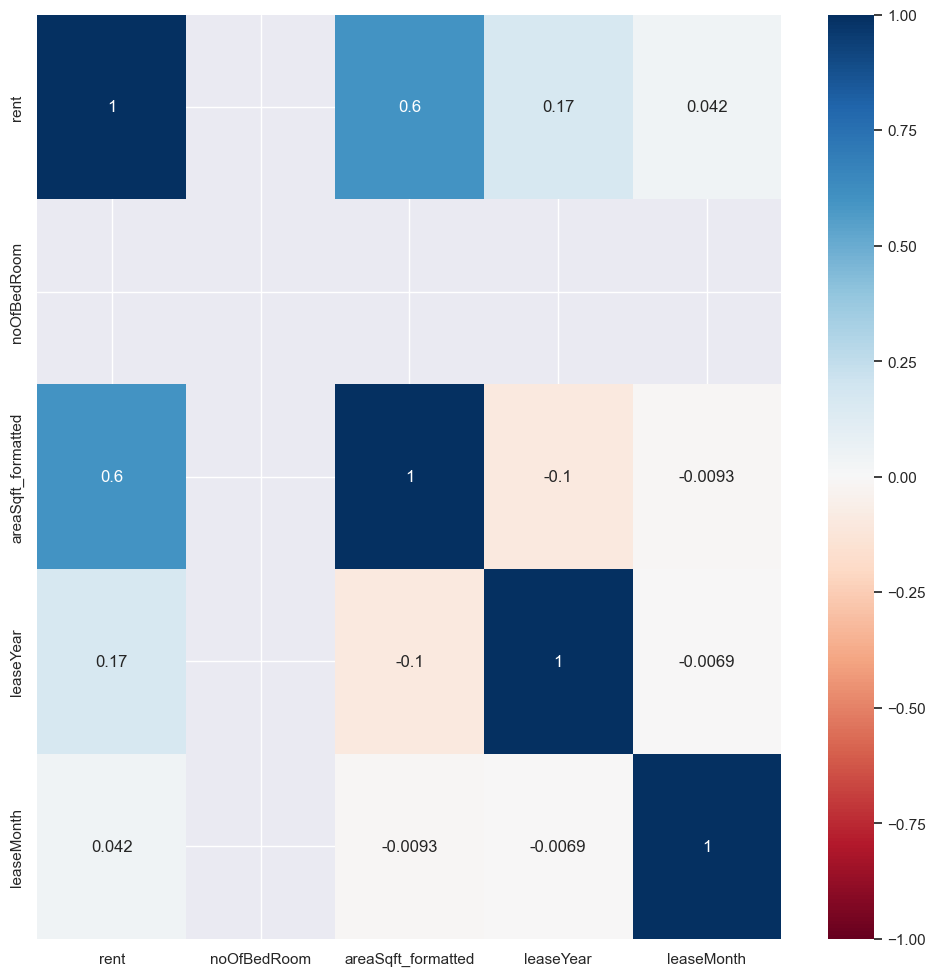

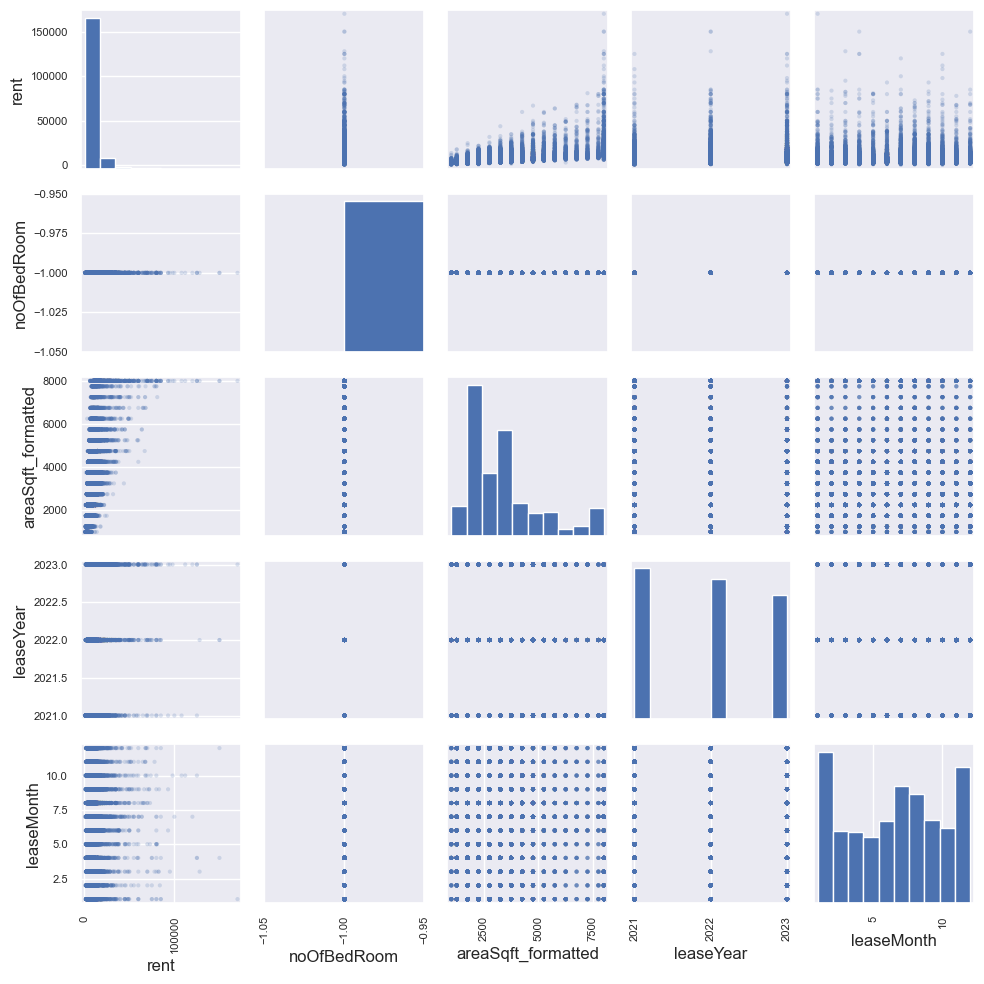

In [38]:
numerical_cols = ['rent', 'noOfBedRoom', 
       'areaSqft_formatted',
       'leaseYear', 'leaseMonth', ]
get_corr_plot(landed[numerical_cols])
pairs(landed[numerical_cols] )

# Modelling

## No transformations

### Landed

['areaSqft_formatted', 'leaseYear', 'leaseMonth', 'district_2', 'district_3', 'district_4', 'district_5', 'district_7', 'district_8', 'district_9', 'district_10', 'district_11', 'district_12', 'district_13', 'district_14', 'district_15', 'district_16', 'district_17', 'district_18', 'district_19', 'district_20', 'district_21', 'district_22', 'district_23', 'district_25', 'district_26', 'district_27', 'district_28', 'propertyType_Semi-Detached House', 'propertyType_Terrace House']
                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     571.6
Date:                Wed, 24 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:11:12   Log-Likelihood:            -1.6620e+05
No. Observations:               16529   AI

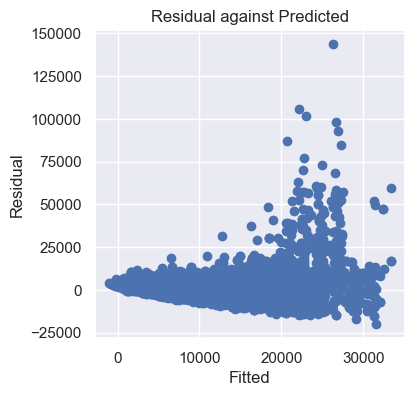

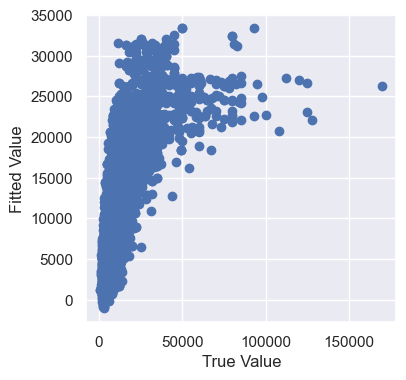

MSE using testing data = 33662108.04163591
RMSE using testing data= 5801.905552629749
MAE using testing data = 2995.997621113668


In [39]:
X_features = list(landed_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent', 'psf75', 'median', 'psf25', 'noOfBedRoom']:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)
    
for col in ['leaseQuarter',]:
    # remove cols causing high colinearity
    X_features.remove(col)
print(X_features)

X_train_df, X_test_df, y_train, y_test = train_test_split(landed_encoded[X_features], landed_encoded["rent"], test_size=0.2, random_state=42)
results = run_lrm(X_train_df, y_train, X_test_df, y_test, scaler=MinMaxScaler(), features=X_features)

### Non-landed

['noOfBedRoom', 'areaSqft_formatted', 'leaseYear', 'leaseQuarter', 'leaseMonth', 'district_2', 'district_3', 'district_4', 'district_5', 'district_6', 'district_7', 'district_8', 'district_9', 'district_10', 'district_11', 'district_12', 'district_13', 'district_14', 'district_15', 'district_16', 'district_17', 'district_18', 'district_19', 'district_20', 'district_21', 'district_22', 'district_23', 'district_25', 'district_26', 'district_27', 'district_28', 'propertyType_Non-landed Properties']


                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                 1.101e+04
Date:                Wed, 24 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:11:14   Log-Likelihood:            -1.8503e+06
No. Observations:              208900   AIC:                         3.701e+06
Df Residuals:                  208868   BIC:                         3.701e+06
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

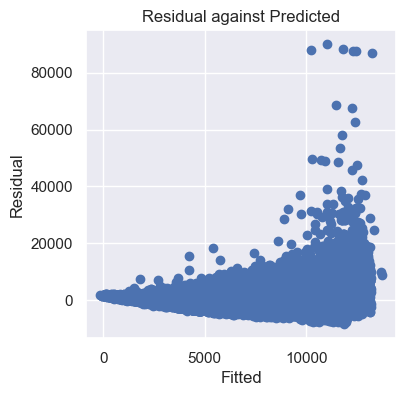

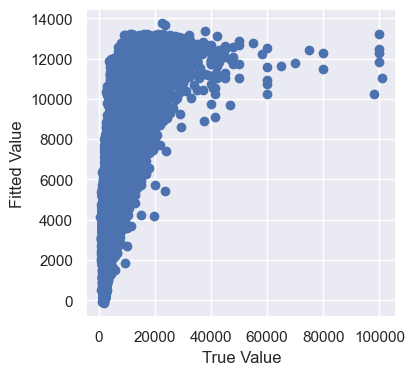

MSE using testing data = 2874010.464301737
RMSE using testing data= 1695.2906725106868
MAE using testing data = 954.6876105200799


In [40]:
X_features = list(nonlanded_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent', 'psf75', 'median', 'psf25',]:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)
print(X_features)
for col in ['leaseQuarter',]:
    # remove cols causing high colinearity
    X_features.remove(col)

X_train_df, X_test_df, y_train, y_test = train_test_split(nonlanded_encoded[X_features], nonlanded_encoded["rent"], test_size=0.2, random_state=42)
results = run_lrm(X_train_df, y_train, X_test_df, y_test, scaler=MinMaxScaler(), features=X_features)

## Ln Y

### Landed

['areaSqft_formatted', 'leaseYear', 'leaseMonth', 'district_2', 'district_3', 'district_4', 'district_5', 'district_7', 'district_8', 'district_9', 'district_10', 'district_11', 'district_12', 'district_13', 'district_14', 'district_15', 'district_16', 'district_17', 'district_18', 'district_19', 'district_20', 'district_21', 'district_22', 'district_23', 'district_25', 'district_26', 'district_27', 'district_28', 'propertyType_Semi-Detached House', 'propertyType_Terrace House']
                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     1117.
Date:                Wed, 24 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:11:15   Log-Likelihood:                -5632.3
No. Observations:               16529   AI

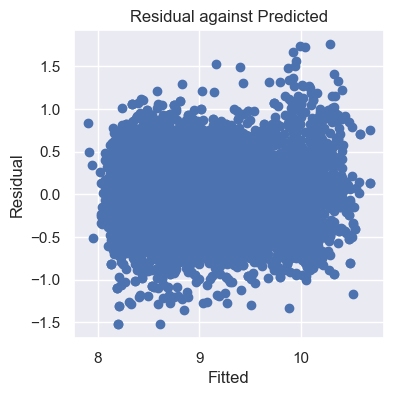

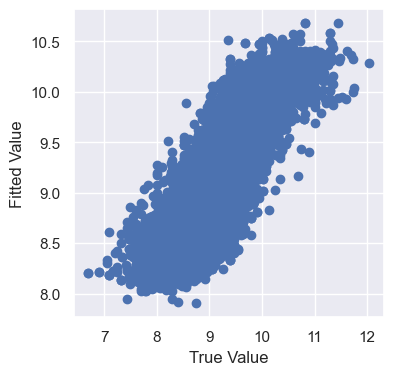

MSE using testing data = 0.11944399701260065
RMSE using testing data= 0.3456067085758039
MAE using testing data = 0.27091808155666125


In [41]:
X_features = list(landed_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent', 'psf75', 'median', 'psf25', 'noOfBedRoom']:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)
    
for col in ['leaseQuarter',]:
    # remove cols causing high colinearity
    X_features.remove(col)
print(X_features)

X_train_df, X_test_df, y_train, y_test = train_test_split(landed_encoded[X_features], np.log(landed_encoded["rent"]), test_size=0.2, random_state=42)
results = run_lrm(X_train_df, y_train, X_test_df, y_test, scaler=MinMaxScaler(), features=X_features)

### Non-landed

['noOfBedRoom', 'areaSqft_formatted', 'leaseYear', 'leaseQuarter', 'leaseMonth', 'district_2', 'district_3', 'district_4', 'district_5', 'district_6', 'district_7', 'district_8', 'district_9', 'district_10', 'district_11', 'district_12', 'district_13', 'district_14', 'district_15', 'district_16', 'district_17', 'district_18', 'district_19', 'district_20', 'district_21', 'district_22', 'district_23', 'district_25', 'district_26', 'district_27', 'district_28', 'propertyType_Non-landed Properties']
                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                 2.168e+04
Date:                Wed, 24 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:11:17   Log-Likelihood:                 20746.
No. Observations:        

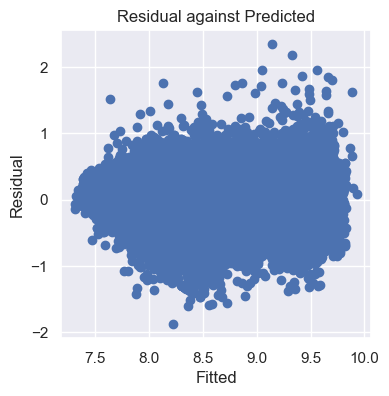

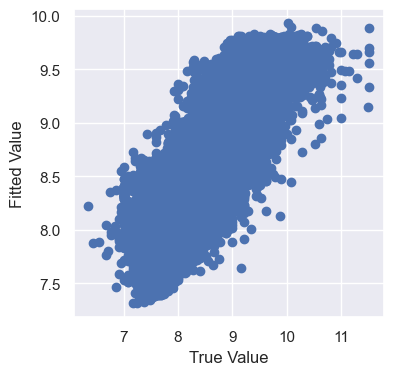

MSE using testing data = 0.04872553001536341
RMSE using testing data= 0.22073860109949825
MAE using testing data = 0.16664809138413175


In [42]:
X_features = list(nonlanded_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent', 'psf75', 'median', 'psf25',]:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)
print(X_features)
for col in ['leaseQuarter',]:
    # remove cols causing high colinearity
    X_features.remove(col)

X_train_df, X_test_df, y_train, y_test = train_test_split(nonlanded_encoded[X_features], np.log(nonlanded_encoded["rent"]), test_size=0.2, random_state=42)
results = run_lrm(X_train_df, y_train, X_test_df, y_test, scaler=MinMaxScaler(), features=X_features)

## Backward Selection

### Landed

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     1197.
Date:                Wed, 24 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:11:19   Log-Likelihood:                -5632.9
No. Observations:               16529   AIC:                         1.132e+04
Df Residuals:                   16500   BIC:                         1.155e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

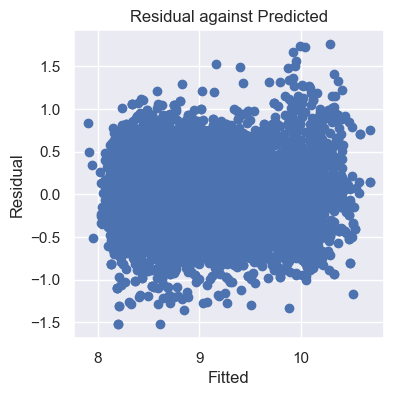

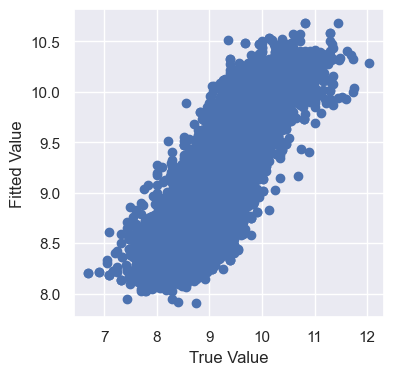

MSE using testing data = 0.11949922128762583
RMSE using testing data= 0.3456865940235835
MAE using testing data = 0.2709857673586321
MAE calculated from reverse transformed predictions: 2634.2209892794976


In [43]:
X_features = list(landed_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent', 'psf75', 'median', 'psf25', 'noOfBedRoom']:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)
    
for col in ['leaseQuarter',]:
    # remove cols causing high colinearity
    X_features.remove(col)

X_train_df, X_test_df, y_train, y_test = train_test_split(landed_encoded[X_features], np.log(landed_encoded["rent"]), test_size=0.2, random_state=42)
backwards_selection_results = backwards_selection(X_train_df, y_train, X_test_df, y_test, scaler=MinMaxScaler(), features=X_features)

test_result_df = backwards_selection_results["result_df"]
test_result_df["predicted_rent"] = np.exp(test_result_df["fitted"])
test_result_df["rent"] = np.exp(test_result_df["true"])
print(f"""MAE calculated from reverse transformed predictions: {mean_absolute_error(test_result_df["rent"], test_result_df["predicted_rent"])}""")

### Non-landed

                            OLS Regression Results                            
Dep. Variable:                   rent   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                 2.095e+04
Date:                Wed, 24 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:11:21   Log-Likelihood:                 15450.
No. Observations:              208900   AIC:                        -3.084e+04
Df Residuals:                  208869   BIC:                        -3.052e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

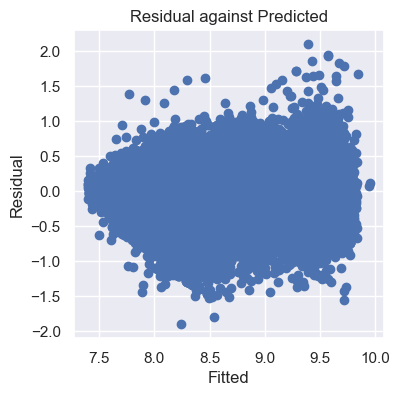

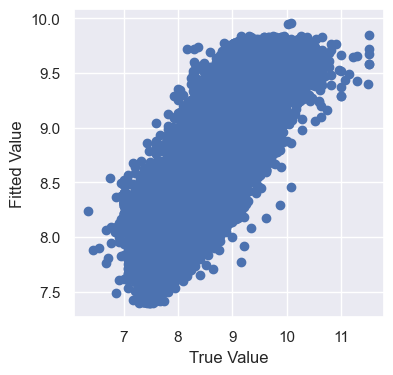

MSE using testing data = 0.051156707532202375
RMSE using testing data= 0.2261784860065218
MAE using testing data = 0.17104222164674135
MAE calculated from reverse transformed predictions: 824.3019735961944


In [44]:
X_features = list(nonlanded_encoded.columns)
for col in ['leaseDate', 'street', 'x', 'y', 'project', 'refPeriod', 'rent', 'psf75', 'median', 'psf25', 'noOfBedRoom']:
    # remove these non-numerical / irrelavant features / target
    X_features.remove(col)
    
for col in ['leaseQuarter',]:
    # remove cols causing high colinearity
    X_features.remove(col)

X_train_df, X_test_df, y_train, y_test = train_test_split(nonlanded_encoded[X_features], np.log(nonlanded_encoded["rent"]), test_size=0.2, random_state=42)
backwards_selection_results = backwards_selection(X_train_df, y_train, X_test_df, y_test, scaler=MinMaxScaler(), features=X_features)

test_result_df = backwards_selection_results["result_df"]
test_result_df["predicted_rent"] = np.exp(test_result_df["fitted"])
test_result_df["rent"] = np.exp(test_result_df["true"])
print(f"""MAE calculated from reverse transformed predictions: {mean_absolute_error(test_result_df["rent"], test_result_df["predicted_rent"])}""")